## **CIFAR-10 Dataset**
The CIFAR-10 dataset is a widely used benchmark dataset in the field of computer vision and machine learning. CIFAR stands for the Canadian Institute for Advanced Research, which originally collected the dataset. It consists of 60,000 32x32 color images in 10 different classes, with 6,000 images per class. The dataset is split into 50,000 training images and 10,000 testing images.

The 10 classes in the CIFAR-10 dataset are:
1. Airplane
2. Automobile
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck

The dataset is commonly used for training and evaluating machine learning models, especially for tasks such as image classification, object recognition, and transfer learning. Its relatively small size and diversity make it suitable for experimentation and research purposes.

### Data Loading and Preprocessing

In [255]:
# Importing the necessary libraries
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import load_model
import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing import image as keras_image



In [160]:
# Function to unpickle a file and return the content as a dictionary
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')  # Unpickle the file
    return dict  # Return the unpickled dictionary

# Paths to the data batches
data_batch_paths = ['cifar-10-batches-py/data_batch_1', 'cifar-10-batches-py/data_batch_2', 'cifar-10-batches-py/data_batch_3', 'cifar-10-batches-py/data_batch_4', 'cifar-10-batches-py/data_batch_5', 'cifar-10-batches-py/test_batch']

data_batches = []  # Initialize a list to store unpickled data batches

# Load each data batch
for path in data_batch_paths:
    data_batches.append(unpickle(path))  # Append the unpickled dictionary to the list

# Extracting data and labels from data batches
X_train = np.concatenate([batch[b'data'] for batch in data_batches[:-1]])  # Concatenate image data arrays
y_train = np.concatenate([batch[b'labels'] for batch in data_batches[:-1]])  # Concatenate label arrays
X_test = data_batches[-1][b'data']  # Extract image data from the last data batch
y_test = data_batches[-1][b'labels']  # Extract labels from the last data batch

# Reshape and normalize pixel values
X_train = X_train.reshape((len(X_train), 3, 32, 32)).transpose(0, 2, 3, 1)  # Reshape and transpose training data
X_test = X_test.reshape((len(X_test), 3, 32, 32)).transpose(0, 2, 3, 1)  # Reshape and transpose testing data
X_train = X_train.astype('float32') / 255  # Normalize training data by dividing by 255
X_test = X_test.astype('float32') / 255  # Normalize testing data by dividing by 255

# Print information about the dataset
print("Shape of training data:", X_train.shape)
print("Shape of testing data:", X_test.shape)
print("Number of training samples:", len(X_train))
print("Number of testing samples:", len(X_test))

Shape of training data: (50000, 32, 32, 3)
Shape of testing data: (10000, 32, 32, 3)
Number of training samples: 50000
Number of testing samples: 10000


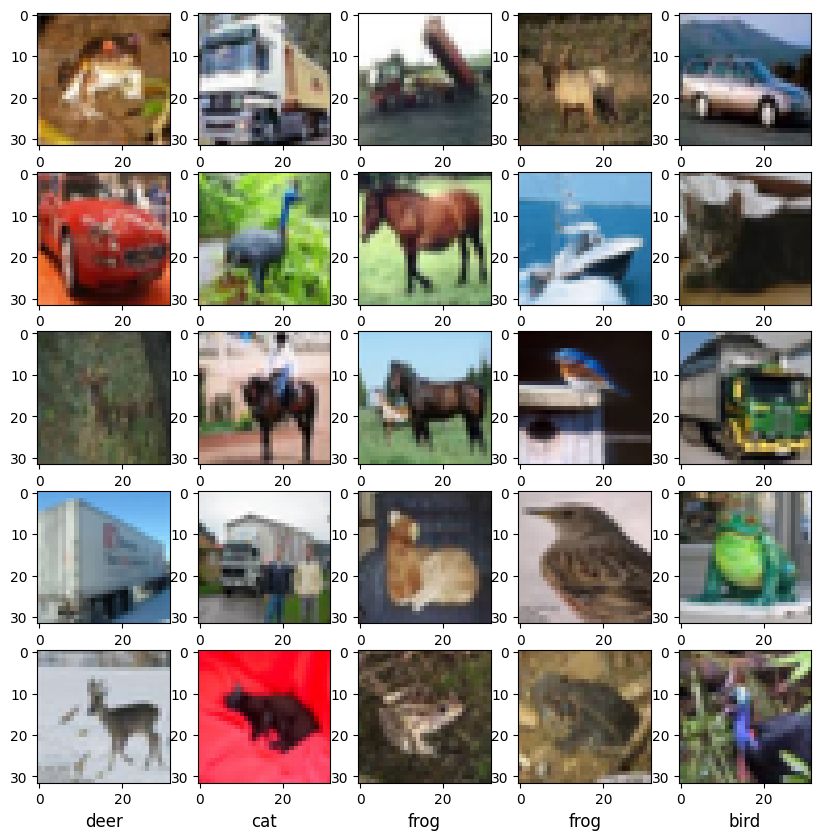

In [219]:
# Define CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Display a few sample images with their corresponding labels
plt.figure(figsize=(10, 10))  # Set the figure size for plotting
for i in range(25):  # Loop through 25 samples
    plt.subplot(5, 5, i + 1)  # Create subplots in a 5x5 grid
    plt.imshow(X_train[i], cmap=plt.cm.binary)  # Display the image
    # Convert the label index to the corresponding class name and set it as xlabel
    plt.xlabel(class_names[y_train[i]], fontsize=12)
plt.show()  # Show the plot


In [220]:
# Calculate mean and standard deviation of training data
mean = np.mean(X_train, axis=(0, 1, 2))  # Calculate mean along axes (0, 1, 2)
std = np.std(X_train, axis=(0, 1, 2))  # Calculate standard deviation along axes (0, 1, 2)

# Apply z-score normalization to training and testing data
X_train_normalized = (X_train - mean) / std  # Normalize training data using z-score normalization
X_test_normalized = (X_test - mean) / std  # Normalize testing data using z-score normalization

# Print mean and standard deviation of training data after normalization
print("Mean of training data (after normalization):", np.mean(X_train_normalized, axis=(0, 1, 2)))  # Print mean after normalization
print("Standard deviation of training data (after normalization):", np.std(X_train_normalized, axis=(0, 1, 2)))  # Print standard deviation after normalization

Mean of training data (after normalization): [-4.9009900e-06 -2.2219915e-06  5.1376878e-07]
Standard deviation of training data (after normalization): [0.99999595 1.0000024  1.0000004 ]


In [164]:
# Convert labels to NumPy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Reshape labels to (-1, 1) to fit OneHotEncoder
y_train_reshaped = y_train.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

# Initialize OneHotEncoder
encoder = OneHotEncoder(categories='auto', sparse=False)

# Fit and transform the training labels
y_train_one_hot = encoder.fit_transform(y_train_reshaped)

# Transform the testing labels
y_test_one_hot = encoder.transform(y_test_reshaped)

# Print the shape of one-hot encoded labels
print("Shape of one-hot encoded training labels:", y_train_one_hot.shape)
print("Shape of one-hot encoded testing labels:", y_test_one_hot.shape)

Shape of one-hot encoded training labels: (50000, 10)
Shape of one-hot encoded testing labels: (10000, 10)


c:\Users\HP G8\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [173]:
# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=10,          # Increase rotation range to 10 degrees
    width_shift_range=0.05,      # Increase width shift range to 5%
    height_shift_range=0.05,     # Increase height shift range to 5%
    shear_range=10,             # Increase shear intensity to 10 degrees
    zoom_range=0.1,             # Increase zoom range to 10%
    horizontal_flip=True,       # Keep horizontal flip
    vertical_flip=True,         # Add vertical flip
    channel_shift_range=0.1,    # Increase channel shift intensity
    brightness_range=[0.5, 1.5] # Change brightness levels randomly
)


# Fit the data augmentation generator to the training data
datagen.fit(X_train)

# Example of using data augmentation during training
# Specify batch size
batch_size = 32

# Generate augmented data
augmented_data = datagen.flow(X_train, y_train_one_hot, batch_size=batch_size)

### Exploratory Data Analysis

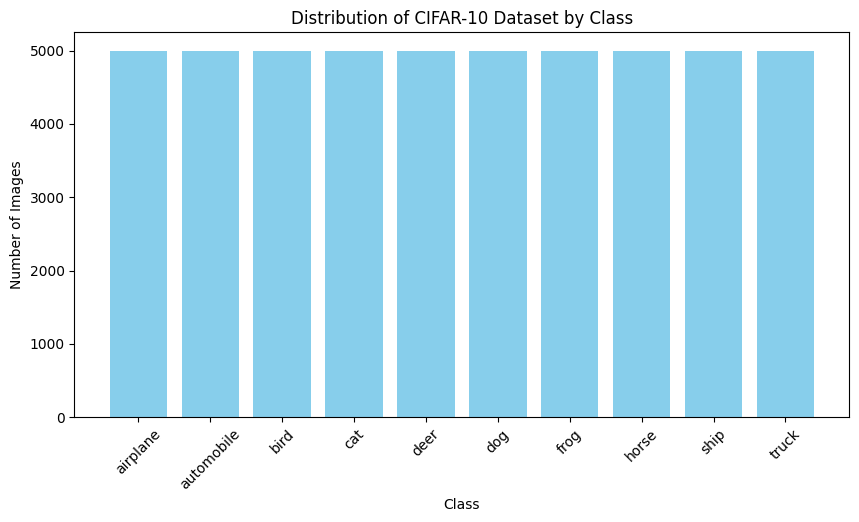

In [221]:
# Count the number of images in each class
class_counts = np.bincount(y_train)

# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the distribution of the data by class
plt.figure(figsize=(10, 5))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of CIFAR-10 Dataset by Class')
plt.xticks(rotation=45)
plt.show()

The bar graph shows that training dataset is evenly distributed among its ten classes, with each class containing 5000 images. The classes include airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. This equal distribution is important as it ensures that a machine learning model trained on this dataset does not become biased towards any particular class. It also allows for a fair evaluation of the model’s performance across all classes.

In [213]:
# Get the dimensions of the images
image_size_train = X_train.shape[1:3]
image_size_test = X_test.shape[1:3]

# Check if all images have consistent sizes
consistent_size = np.all(image_size_train == image_size_train[0]) and np.all(image_size_test == image_size_test[0])

# Print the image sizes
print("Image size of training data:", image_size_train)
print("Image size of testing data:", image_size_test)

# Check if all images have consistent sizes
if consistent_size:
    print("All images have consistent sizes.")
else:
    print("Not all images have consistent sizes.")

Image size of training data: (32, 32)
Image size of testing data: (32, 32)
Not all images have consistent sizes.


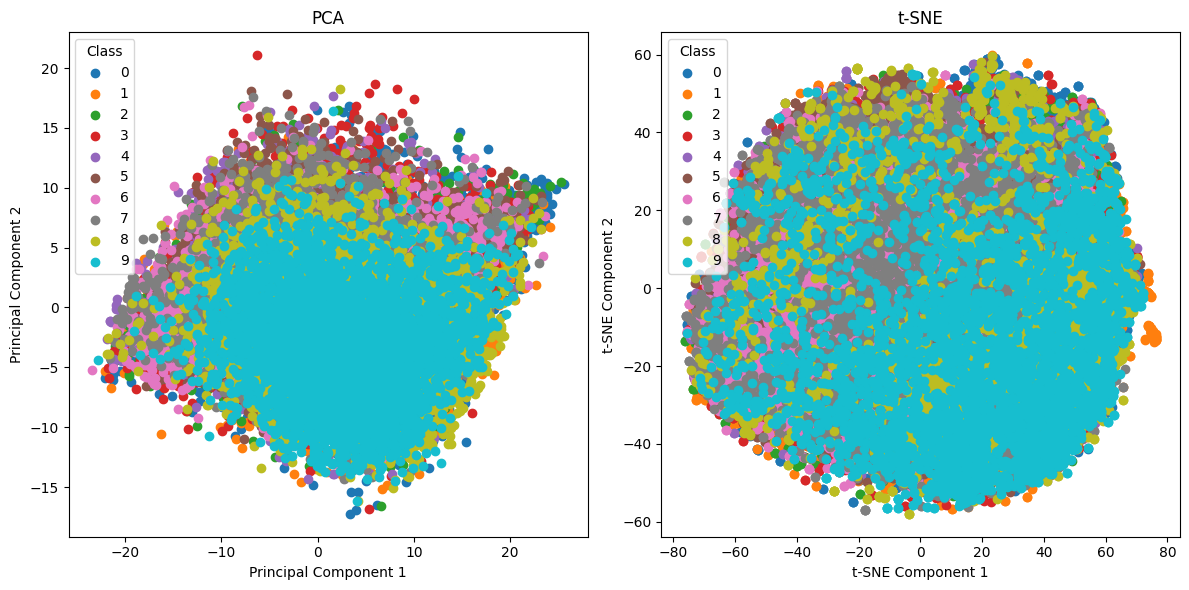

In [217]:
# Reshape the training data to 2D (num_samples, num_features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=50)  # Specify the number of components to retain
X_train_pca = pca.fit_transform(X_train_flat)

# Perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)  # Specify the number of components and random state
X_train_tsne = tsne.fit_transform(X_train_flat)

# Plot 2D embeddings of images colored by class labels
plt.figure(figsize=(12, 6))

# Plot PCA embeddings
plt.subplot(1, 2, 1)
for i in range(10):
    plt.scatter(X_train_pca[y_train == i, 0], X_train_pca[y_train == i, 1], label=str(i))
plt.title('PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Class')

# Plot t-SNE embeddings
plt.subplot(1, 2, 2)
for i in range(10):
    plt.scatter(X_train_tsne[y_train == i, 0], X_train_tsne[y_train == i, 1], label=str(i))
plt.title('t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Class')

plt.tight_layout()
plt.show()

The image above shows the comparison between PCA and t-SNE. The PCA plot shows data points scattered in a somewhat oval shape. The overlap of colors in this plot suggests that PCA might not be able to effectively separate the different classes in the dataset. On the other hand, the t-SNE plot shows a more evenly distributed cluster of data points with better separation of colors. This suggests that t-SNE is more effective at separating different classes in the CIFAR-10 dataset. When comparing the two plots, it’s clear that t-SNE provides a better separation of classes than PCA for the CIFAR-10 dataset. This could be due to the fact that t-SNE preserves the local structure of the data, making it a good choice for visualizing high-dimensional data in two dimensions.

### Model Building and Training

In [174]:
# Input layer
inputs = Input(shape=(32, 32, 3))

# Set the weight decay value for L2 regularization
weight_decay = 0.0001

# First convolutional block
x = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(inputs)
x = BatchNormalization()(x)
x = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Second convolutional block
x = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.3)(x)

# Third convolutional block
x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.4)(x)

# Fourth convolutional block
x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.5)(x)

# Flatten the output
x = Flatten()(x)

# Output layer
outputs = Dense(10, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

In [175]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [176]:
# Display the model summary
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_104 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_98 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_105 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_99 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_55 (MaxPooli  (None, 16, 16, 32)        0  

 The above model architecture is a Convolutional Neural Network (CNN). It begins with an input layer configured to accept images of size 32x32 pixels with RGB color channels. The model consists of four convolutional blocks, each containing two convolutional layers followed by batch normalization, ReLU activation, and max-pooling. The number of filters in each block increases progressively (32, 64, 128, 256), allowing the model to capture increasingly complex features. Dropout layers are inserted after each max-pooling operation with increasing dropout rates (0.2, 0.3, 0.4, 0.5) to prevent overfitting by randomly dropping connections between neurons during training.

After the final convolutional block, the output is flattened into a one-dimensional vector to be fed into a fully connected layer. The output layer consists of a dense layer with 10 units and softmax activation providing the probability distribution over the 10 classes. L2 regularization with a weight decay value of 0.0001 is applied to the convolutional kernels to mitigate overfitting and control the model's complexity.

In [177]:
# Train the model
history = model.fit(datagen.flow(X_train_normalized, y_train_one_hot, batch_size=32),
                    epochs=50,
                    validation_data=(X_test_normalized, y_test_one_hot))

Epoch 1/50
1563/1563 [==============================] - 313s 199ms/step - loss: 2.3630 - accuracy: 0.3096 - val_loss: 1.7914 - val_accuracy: 0.4083
Epoch 2/50
1563/1563 [==============================] - 297s 190ms/step - loss: 1.7926 - accuracy: 0.4388 - val_loss: 1.3998 - val_accuracy: 0.5529
Epoch 3/50
1563/1563 [==============================] - 288s 184ms/step - loss: 1.5734 - accuracy: 0.5150 - val_loss: 1.3823 - val_accuracy: 0.5821
Epoch 4/50
1563/1563 [==============================] - 284s 181ms/step - loss: 1.4548 - accuracy: 0.5654 - val_loss: 1.2365 - val_accuracy: 0.6460
Epoch 5/50
1563/1563 [==============================] - 286s 183ms/step - loss: 1.3781 - accuracy: 0.5996 - val_loss: 1.3253 - val_accuracy: 0.6257
Epoch 6/50
1563/1563 [==============================] - 286s 183ms/step - loss: 1.3306 - accuracy: 0.6245 - val_loss: 1.2247 - val_accuracy: 0.6560
Epoch 7/50
1563/1563 [==============================] - 324s 208ms/step - loss: 1.2896 - accuracy: 0.6459 - val_

### Model Evaluation

In [178]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test_normalized, y_test_one_hot, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 11s - loss: 0.9872 - accuracy: 0.7699 - 11s/epoch - 36ms/step

Test accuracy: 0.7699000239372253


313/313 [==============================] - 12s 37ms/step - loss: 0.9872 - accuracy: 0.7699
Validation Loss: 0.9872286319732666
Validation Accuracy: 0.7699000239372253


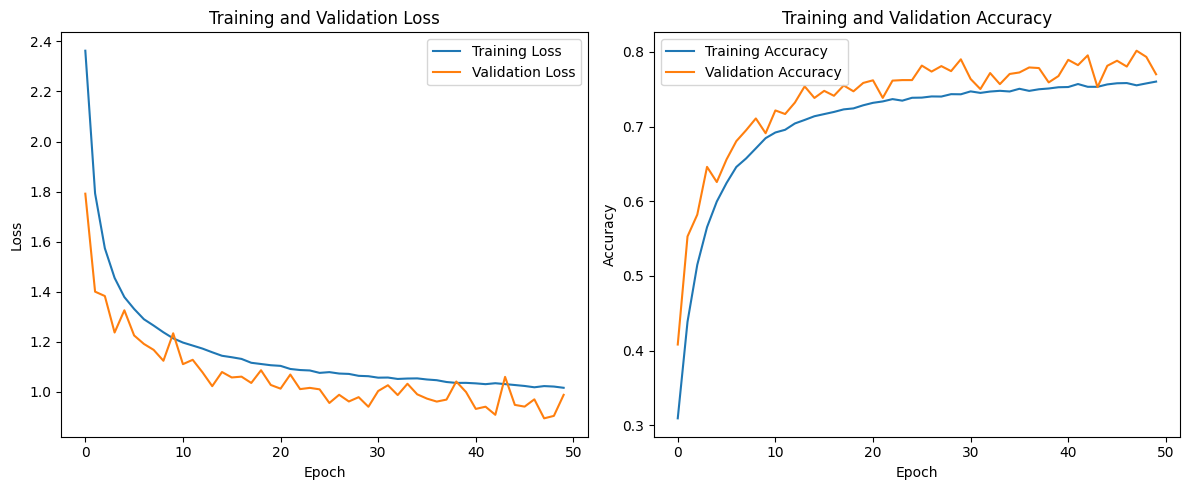

In [181]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_test_normalized, y_test_one_hot)

print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')

# Visualize the training process
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

The validation loss is approximately 0.987, and the validation accuracy is approximately 0.770 with 50 epochs. This suggests that the model is fairly accurate. Also, both the training and validation loss are continually decreasing which means that the model is learning and improving its performance on both the training and validation datasets.


313/313 [==============================] - 13s 41ms/step
Accuracy: 0.77
Precision: 0.6624720335535093
Recall: 0.427
F1-score: 0.4096794396200682


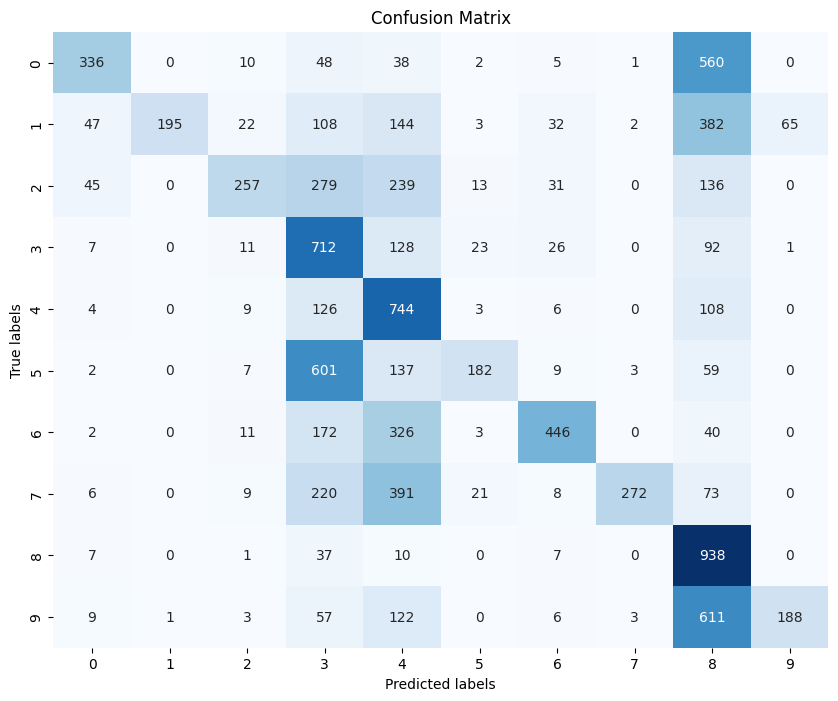

In [235]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


Based on the confusion matrix, it seems that the classes ‘cat’, ‘deer’, and ‘ship’ have the most accurate predictions, indicating that your model is performing well on these classes.

On the other hand, the classes ‘truck’, ‘dog’, and ‘automobile’ might need improvement. This could mean that these classes are being misclassified more often.

In [218]:
# Save the model
model.save('my_model.h5')

c:\Users\HP G8\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Real Time Prediction

In [260]:
test_file = "frog.jpg"
# Load the image
image = cv2.imread(test_file)
# Convert the image from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

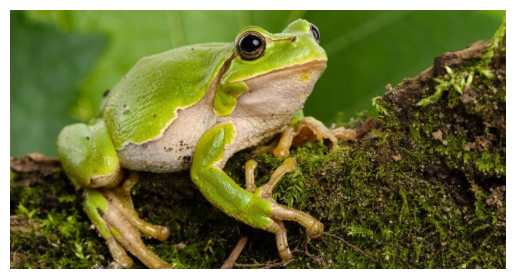

In [261]:
plt.imshow(image)
plt.axis('off')
plt.show()

In [258]:
# Resize the image to match the input size of your model
target_size = (32, 32)
resized_image = cv2.resize(image, target_size)

# Convert to numpy array and normalize if needed
normalized_image = resized_image.astype(np.float32) / 255.0

# Add batch dimension if needed
input_image = np.expand_dims(normalized_image, axis=0)

In [257]:
# Load the saved model
loaded_model = load_model('my_model.h5')

# Do prediction to the new data
prediction = loaded_model.predict(input_image)
predicted_class = prediction.argmax()

# Print the prediction
print('Prediction: ', class_names[predicted_class])

1/1 [==============================] - 0s 190ms/step
Prediction:  frog


The model accurately predicted the frog from the unseen image. Now let's explore the misclassified images.

1/1 [==============================] - 0s 261ms/step


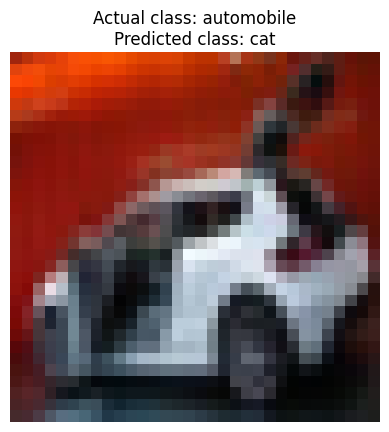

In [254]:
# Reshape the image to match the model input shape 
test_image = np.expand_dims(X_test[6], axis=0)

# Load the saved model
loaded_model = load_model('my_model.h5')

# Make a prediction using the trained model
prediction = loaded_model.predict(test_image)

# Get the predicted class label (index with highest probability)
predicted_class_index = np.argmax(prediction)

# Map the predicted class index to the class name
predicted_class_name = class_names[predicted_class_index]

# Get the actual class label
actual_class_index = y_test[image_index]
actual_class_name = class_names[actual_class_index]

# Display the image along with actual and predicted labels
plt.imshow(X_test[image_index])
plt.title("Actual class: " + actual_class_name + "\nPredicted class: " + predicted_class_name)
plt.axis('off')
plt.show()


### Results Interpretation:

**Performance Metrics:**
- The trained Convolutional Neural Network (CNN) model achieved a test accuracy of approximately 76.99% on the CIFAR-10 dataset.
- The model's performance was evaluated using accuracy, which measures the proportion of correctly classified images out of the total number of images in the test set.

**Challenges Encountered:**
- The CNN model may have encountered challenges due to the complexity and diversity of the CIFAR-10 dataset. Some images in the dataset may be visually similar, making classification more challenging.
- Training deep neural networks like CNNs can be computationally expensive and may require significant computational resources and time.
- Balancing between model complexity and overfitting is another challenge. While a more complex model can capture intricate patterns, it may also lead to overfitting, especially with limited training data.

**Misclassified Images:**
- Exploring misclassified images can provide insights into the model's weaknesses and potential areas for improvement. Misclassifications may occur due to ambiguous images, class imbalance, or limitations in the model's capacity to capture complex patterns.
- Analyzing misclassified images can involve visual inspection of misclassified samples, identifying common patterns or characteristics among misclassified images, and considering potential strategies to address these challenges, such as fine-tuning the model architecture or increasing the diversity of the training data.

### Conclusion and Recommendations:

**Findings and Conclusions:**
- The CNN model achieved a reasonable test accuracy of approximately 76.99% on the CIFAR-10 dataset, indicating its capability to classify images into the correct classes.
- Preprocessing steps such as normalization, one-hot encoding, and data augmentation contributed to improving the model's performance and generalization ability.
- Challenges encountered during training and evaluation, such as computational complexity and potential overfitting, highlight the need for careful model selection, hyperparameter tuning, and regularization techniques.

**Recommendations:**
- Further Model Evaluation: Conduct a thorough analysis of misclassified images to identify specific patterns or classes that the model struggles with. This analysis can guide future model improvements.
- Model Optimization: Experiment with different model architectures, hyperparameters, and regularization techniques to improve model performance further.
- Ensemble Learning: Explore ensemble learning techniques to combine predictions from multiple models, potentially improving overall classification accuracy and robustness.
- Transfer Learning: Investigate the use of transfer learning from pre-trained models, leveraging features learned from large datasets to improve performance on CIFAR-10.